In [8]:
import math
import datasets
import debug_helpers
import datetime

import collections
import aer
import warnings
import numpy as np

import persistence
import plots

# pretty print variabeles on line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# returns list with jump probabilities 
# (and special NULL jump probability)
# [-max_jump ....0 ...max_jump, NULL_jump]
def _initialize_jump_probs(sentence_pairs):
    max_jump = 0
    for (s_sentence, t_sentence) in sentence_pairs:
        s_length = len(s_sentence) - 1 #ignore NULL
        t_length = len(t_sentence)
        jump_1 = abs(1 - math.floor(s_length))
        jump_2 = abs(s_length - math.floor(s_length/t_length))
        max_jump = max(jump_1, jump_2, max_jump)
    init_prob = 1. / (2*max_jump + 1 + 1) # last item is special NULL jump prob
    return [init_prob] * (2*max_jump + 1 + 1)

# returns the index in the jump_probabilities list
# for given source and target positions and sentence lengths
# s_pos and s_length for source sentence including the special NULL word
# sentence positions start at index 0
def get_jump_prob_index(s_pos, t_pos, s_length, t_length, jump_probs):
    if s_pos == 0:
        return len(jump_probs) - 1
    jump = int(s_pos - math.floor((t_pos + 1) * (s_length - 1) / t_length))
    max_jump = int((len(jump_probs) - 2)/2)
    jump_prob_index = jump + max_jump
    if jump_prob_index < 0:
        warnings.warn(
            f'Jump prob index {jump_prob_index} (jump:{jump}) out of range.'
        )
        return 0 #approximate with prob of largest negative jump
    if jump_prob_index >= len(jump_probs) - 1:
        warnings.warn(
            f'Jump prob index {jump_prob_index} (jump:{jump}) out of range.'
        )
        return len(jump_probs) - 2 #approximate with prob of largest positive jump

    return jump_prob_index

# returns jump probability for given source and target positions
# and lengths. Positions start at index 0, source sentence contains
# special NULL word at position 0
def get_jump_prob(s_pos, t_pos, s_length, t_length, jump_probs):
    jump_prob_index = get_jump_prob_index(s_pos, t_pos, s_length, t_length, jump_probs)
    return jump_probs[jump_prob_index]

In [3]:
# {Hause: { book:0.25, ...}, ...}
# read: the probability of 'book' given 'Haus' is 0.25
def _initialize_lexicon_probabilities(source_vocabulary, target_vocabulary):
    p_init = 1./len(target_vocabulary)
    lexicon_probabilities = collections.defaultdict(
        lambda: collections.defaultdict(lambda: p_init))
    return lexicon_probabilities

In [4]:
def source_dependencies(s_sentence, t_word, t_pos, t_length, lprobs, jump_probs):
    s_length = len(s_sentence)    
    jump_probs = [get_jump_prob(
        s_word_pos, t_pos, s_length, t_length, jump_probs
    ) for s_word_pos in range(s_length)]
    sum_jump_probs = sum(jump_probs)
    
    return [
        (jump_probs[s_pos]/ sum_jump_probs) * lprobs[s_word][t_word] 
        for s_pos, s_word in enumerate(s_sentence)
    ]

In [5]:
def align(lprobs, jump_probs, sentence_pairs):
    if isinstance(sentence_pairs, tuple):
        return _align_sentence_pair(lprobs, jump_probs, sentence_pairs)
    return [ _align_sentence_pair(lprobs, jump_probs, sentence_pair) for sentence_pair in sentence_pairs ]

def _align_sentence_pair(lprobs, jump_probs, sentence_pair):
    s_sentence = sentence_pair[0]
    t_sentence = sentence_pair[1]
    s_length = len(s_sentence)
    t_length = len(t_sentence)
    best_alignment = set()
    for t_pos, t_word in enumerate(t_sentence):
        sd = source_dependencies(s_sentence, t_word, t_pos, t_length, lprobs, jump_probs)
        (best_align_pos, _) = max(enumerate(sd), key=lambda t: t[1])
        if (best_align_pos > 0): # Leave out NULL-alignments (and alignments between unseen words)
            best_alignment.add((best_align_pos, t_pos + 1)) # word positions start at 1
    return best_alignment

In [6]:
def EM(s_t_pairs, s_vocabulary, t_vocabulary, max_iterations = 10,
        val_sentence_pairs = None, reference_alignments = None, fn_debug = None):
    lprobs = _initialize_lexicon_probabilities(s_vocabulary, t_vocabulary)
    jump_probs = _initialize_jump_probs(s_t_pairs)
#    print('initial jump probs', jump_probs)
    i = 0
    log_likelihoods = []
    AERs = []
    while i < max_iterations:
        
        # initialize
        log_likelihood = 0
        AER = 0
        counts_t_given_s = collections.defaultdict(lambda: collections.defaultdict(int))
        total_s = collections.defaultdict(int)
        jump_counts = [0]*len(jump_probs)

        # calculate counts and log likelihood
        for (s_sentence, t_sentence) in s_t_pairs:
            s_length = len(s_sentence)
            t_length = len(t_sentence)
            for t_pos, t_word in enumerate(t_sentence):
                prob_counts = source_dependencies(
                    s_sentence, t_word, t_pos, t_length, lprobs, jump_probs)
                s_total_t = sum(prob_counts)
                log_likelihood += math.log(s_total_t)
                                
                for s_pos, s_word in enumerate(s_sentence):
                    update = prob_counts[s_pos]/s_total_t
                    counts_t_given_s[s_word][t_word] += update
                    total_s[s_word] += update
                    jump_count_index = get_jump_prob_index(s_pos, t_pos, s_length, t_length, jump_probs)
                    jump_counts[jump_count_index] += update 
        
        # store log_likelihood and AER values
        log_likelihoods.append(log_likelihood)
        if val_sentence_pairs and reference_alignments:
            predicted_alignments = align(lprobs, jump_probs, val_sentence_pairs)
            AER = aer.calculate_AER(reference_alignments, predicted_alignments)
            AERs.append(AER)

        # print debug info
        if fn_debug:
            fn_debug(i, lprobs, log_likelihood, AER, jump_probs)

        # update probabilities
        for s in lprobs.keys():
            for t in lprobs[s].keys():
                lprobs[s][t] = counts_t_given_s[s][t]/total_s[s]
        
        jump_count_sum = sum(jump_counts)
        jump_probs = [jc/jump_count_sum for jc in jump_counts]

        # update iteration number
        i += 1

    # add AER after final update
    if val_sentence_pairs and reference_alignments:
        predicted_alignments = align(lprobs, jump_probs, val_sentence_pairs)
        AER = aer.calculate_AER(reference_alignments, predicted_alignments)
        AERs.append(AER)
    
    # add llhood after final update
    log_likelihood = 0
    for (s_sentence, t_sentence) in s_t_pairs:
        s_length = len(s_sentence)
        t_length = len(t_sentence)
        for t_pos, t_word in enumerate(t_sentence):
            prob_counts = source_dependencies(
                s_sentence, t_word, t_pos, t_length, lprobs, jump_probs)
            s_total_t = sum(prob_counts)
            log_likelihood += math.log(s_total_t)

    return lprobs, jump_probs, log_likelihoods, AERs


In [7]:
s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_word_order()
(lprobs, jump_probs, _, _) = EM(s_t_pairs, s_vocabulary, t_vocabulary, 
                 fn_debug = None) #debug_helpers.print_likelihood debug_helpers.print_lexicon_probs

assert(round(lprobs['Haus']['house'], 5) == 1.)
assert(round(lprobs['Welt']['world'], 5) == 1.)
assert(round(lprobs['das']['the'], 5) == 1.)
assert(round(lprobs['<NULL>']['house'], 5) == 0.)
assert(round(lprobs['<NULL>']['the'], 5) == 0.49987)

assert(round(jump_probs[0], 5) == 0.49999)
assert(round(jump_probs[1], 5) == 0.0)
assert(round(jump_probs[2], 5) == 0.48086)
assert(round(jump_probs[3], 5) == 0.01915)

print('PASSED!')

s_t_pairs
debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs



PASSED!


[(['<NULL>', 'Haus', 'das'], ['the', 'house']),
 (['<NULL>', 'Buch', 'das'], ['the', 'book']),
 (['<NULL>', 'Buch', 'ein'], ['a', 'book']),
 (['<NULL>', 'Maus', 'ein'], ['a', 'mouse']),
 (['<NULL>', 'Hund', 'das'], ['the', 'dog']),
 (['<NULL>', 'Welt', 'ein'], ['a', 'world']),
 (['<NULL>', 'Boot', 'das'], ['the', 'boat']),
 (['<NULL>', 'Brugge', 'ein'], ['a', 'bridge'])]

<NULL> the 0.49986849923914406
<NULL> house 7.356813242249742e-07
<NULL> book 0.0002585874337666559
<NULL> a 0.49986849923914406
<NULL> mouse 7.356813242249742e-07
<NULL> dog 7.356813242249742e-07
<NULL> world 7.356813242249742e-07
<NULL> boat 7.356813242249742e-07
<NULL> bridge 7.356813242249742e-07
Haus the 4.7469538197000456e-07
Haus house 0.999999525304618
das the 0.999999998669036
das house 3.9810413054863663e-10
das book 1.3665150273143486e-10
das dog 3.9810413054863663e-10
das boat 3.9810413054863663e-10
Buch the 9.415144932164758e-09
Buch book 0.9999999811697101
Buch a 9.415144932164756e-09
ein a 0.9999999986690361
ein book 1.3665150273143486e-10
ein mouse 3.9810413054863663e-10
ein world 3.9810413054863663e-10
ein bridge 3.9810413054863663e-10
Maus a 4.746953819700045e-07
Maus mouse 0.999999525304618
Hund the 4.7469538197000456e-07
Hund dog 0.999999525304618
Welt a 4.746953819700045e-07
Welt world 0.999999525304618
Boot the 4.7469538197000456e-07
Boot boat 0.999999525304618
Br

[0.49999496375577407,
 1.8100451027309263e-07,
 0.4808581819113756,
 0.019146673328340063]

In [ ]:
# Run EM on toy example
s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_null_words()
s_t_pairs[0:3]
(lprobs, jump_probs, _, _) = EM(s_t_pairs[0:3], s_vocabulary, t_vocabulary, 
                 fn_debug = debug_helpers.print_likelihood)

debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs

In [ ]:
# Run EM on toy example with NULL words
val_sentence_pairs = [(
    ['<NULL>', 'Buch', 'klein', 'das', 'Haus'], 
    ['book', 'small', 'the', 'house']
)]
ref_alignments = [[
    {(3, 1), (2, 2), (4, 3), (1, 4)}, 
    {(3, 1), (2, 2), (4, 3), (1, 4)}
]]
s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_null_words()
s_t_pairs
(lprobs, jump_probs, _, _) = EM(
    s_t_pairs, s_vocabulary, t_vocabulary, 20,
    val_sentence_pairs, ref_alignments, debug_helpers.print_likelihood)
debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs

In [9]:
def fname_ibm2(i):
    return f'ibm2_iter_{i}.txt'

# After each iteration we print llhood and AER and store the model 
# We can later load the models that meet our convergence criteria
# and apply those to the test data
def fn_after_iter_ibm2(i, lprobs, log_likelihood, AER, jump_probs):
    debug_helpers.print_likelihood(i, lprobs, log_likelihood, AER)
    if i == 7 or i == 9: # AER and LLhoods
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(i))

# Run EM on training data set with AER on validation set
s_t_pairs, s_vocabulary, t_vocabulary = datasets.training_data()
val_sentence_pairs = datasets.validation_data(s_vocabulary, t_vocabulary)
reference_alignments = datasets.validation_alignments()    

(lprobs, jump_probs, llhoods, AERs) = EM(
    s_t_pairs, s_vocabulary, t_vocabulary, 15,
    val_sentence_pairs, reference_alignments, 
    debug_helpers.fn_after_iter_ibm2)


# plot AER and llhood scores vs iteration
plots.figure_log_likelihood(llhoods, 'IBM2')
plots.figure_AER(AERs, 'IBM2')

# select models based on AER and llhood selection criterion
selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
print('model selected on AER:', selected_model_AER)
print('model selected on LLhood:', selected_model_llhood)

# store AER and llhood scores in file
fname_ibm2_AERs = "ibm2_AERs_iter15.txt"    
fname_ibm2_llhoods = "ibm2_llhoods_iter15.txt"
persistence.save(AERs, fname_ibm2_AERs)
persistence.save(llhoods, fname_ibm2_llhoods)

# store model
#persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(10))


iteration    log_likelihood    AER    time
0 -47715574.425 1.00000 11:50
1 -22684076.993 0.28077 11:59
2 -18085493.286 0.25236 12:07
3 -16414971.999 0.24008 12:15
4 -15953171.581 0.23440 12:23
5 -15816714.535 0.23440 12:32
6 -15758568.021 0.23135 12:40
7 -15728259.606 0.23324 12:48
8 -15710877.500 0.23607 12:56
9 -15700093.969 0.23985 01:04


NameError: name 'llhoods' is not defined

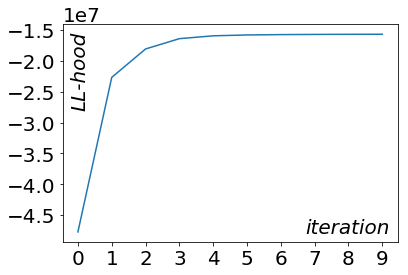

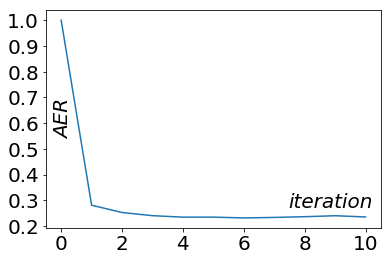

model selected on AER: ibm2_iter_7.txt
model selected on LLhood: ibm2_iter_9.txt


NameError: name 'scores' is not defined

In [13]:
import convergence_criterion as cc



In [20]:
import json
def save_ibm2_model(lprobs, jump_probs, fname):
    ibm2_model = {
        'lprobs' : lprobs, 
        'jump_probs' : jump_probs
    }
    json.dump(ibm2_model, open(fname,'w'))

def load_ibm2_model(fname):
    ibm2_model =  json.load(open(fname))
    return (ibm2_model['lprobs'], ibm2_model['jump_probs'])


In [21]:
def save(data, fname):
    with open(fname, "w") as file:
        file.write(str(data))

In [22]:
save(AERs, fname_ibm2_AERs)
save(llhoods, fname_ibm2_llhoods)

# store model
save_ibm2_model(lprobs, jump_probs, fname_ibm2(10))
